In [137]:
import pandas as pd
from bs4 import BeautifulSoup
from splinter import Browser
from webdriver_manager.chrome import ChromeDriverManager
import pymongo
from flask import Flask, jsonify
import time
import re
import random
from datetime import datetime
import math
import matplotlib.pyplot as plt

In [ ]:
#####CREATE WEB-SCRAPING BOT##########

In [709]:
#opens NYTimes
def open_nytimes():
    browser.visit("https://nytimes.com")

In [710]:
#finds the search icon on the opening page and clicks it
def click_search_icon():
    buttons = browser.find_by_tag('button')

    for button in buttons:
        if (button.value=="SEARCH"):
            button.click()
            break

In [711]:
#fills in the search bar
def enter_text(search_word):

    browser.find_by_tag('input').fill(search_word)

In [712]:
#finds the 'Go' button and clicks it to start search
def click_go():
    buttons = browser.find_by_tag('button')
    #the 'Go' button is the +1 after the search icon
    found = False 

    for button in buttons:
        if (found):
            button.click()
            break
        if (button.value=="SEARCH"):
            found = True

In [713]:
 #return updated html
def get_updated_html():
    thesoup=parser(browser.html)
    thesoup = BeautifulSoup(browser.html, 'html.parser')

    return thesoup

In [714]:
#function to click 'show more'
def show_more ():
    if(browser.is_element_not_present_by_text('Show More')):
        return True
    else:
        browser.find_by_text('Show More').click()
        return False
    

In [715]:
#finds headers
def get_new_headers(soup):
    temps=soup.find_all('h4', class_="css-2fgx4k")

    for temp in temps:
        if (temp.find_parent(href=True)):
            parent=temp.find_parent(href=True)['href']
            if (parent not in articles):
                if(re.search(r'^/\d\d\d\d/\d\d/\d\d/', parent)):
                    titles.append(temp.text)

In [716]:
#finds subheaders
def get_new_subs(soup):
    temps=soup.find_all('p', class_="css-16nhkrn")

    for temp in temps:
        if (temp.find_parent(href=True)):
            parent=temp.find_parent(href=True)['href']
            if (parent not in articles):
                if(re.search(r'^/\d\d\d\d/\d\d/\d\d/', parent)):
                    subheaders.append(temp.text)

In [717]:
#sections
def get_new_sections(soup):
    temps=soup.find_all('p', class_="css-myxawk")

    for temp in temps:
        if (temp.find_parent(href=True)):
            parent=temp.find_parent(href=True)['href']
            if (parent not in articles):
                if(re.search(r'^/\d\d\d\d/\d\d/\d\d/', parent)):
                    sections.append(temp.text)

In [626]:
thelinks=soup.find_all(href=True)
thelinks[61]

<a href="https://artsbeat.blogs.nytimes.com/2010/01/12/glaad-award-nominees-include-glee-true-blood-mad-men-and-precious/?searchResultPosition=34"><h4 class="css-2fgx4k">GLAAD Award Nominees Include ‘Glee,’ ‘True Blood,’ ‘Mad Men’ and ‘Precious’</h4><p class="css-16nhkrn">The Gay &amp; Lesbian Alliance Against Defamation announced the nominees for its annual GLAAD Media Awards, “recognizing and honoring media for outstanding images” of the lesbian, gay, bisexual and transgender people.</p><p class="css-15w69y9">By Dave Itzkoff</p></a>

In [661]:
thelinks[61].parent.find('p', class_="css-myxawk")

<p class="css-myxawk">Arts</p>

In [718]:
#function to pull article data
def get_article_data(soup):
    thelinks=soup.find_all(href=True)

    for link in thelinks:
        
        #makes sure is article rather than a podcast or video, based on link convention
        if(re.search(r'^/\d\d\d\d/\d\d/\d\d/', link['href'])):
            
            #makes sure not already entered into database
            if (link['href'] not in articles):
                
                #extracts the date from the link
                temp=link['href'].split('/')
                dates.append(temp[2] + '/' +  temp[3] + '/' + temp[1])
                articles.append(link['href'])
                
                #finds the title associated with the link
                if(link.find('h4')!=None): 
                    titles.append(link.find('h4').text)
                else: 
                    titles.append("")
                
                #finds the sub text associated with the link
                if(link.find('p', class_="css-16nhkrn")!=None):
                    subheaders.append(link.find('p', class_="css-16nhkrn").text)
                else: 
                    subheaders.append("")
                    
                #finds the section associated with    
                if(link.parent.find('p', class_="css-myxawk")!=None):
                    sections.append(link.parent.find('p', class_="css-myxawk").text)
                else: 
                    sections.append("")
                
                
                #if it doesn't meet the requirements removes it from the list
                if(meets_requirement()==False):
                    titles.pop()
                    subheaders.pop()
                    sections.pop()
                    dates.pop()
                    articles.pop()
                    
         
                    
                    

In [719]:
#checks to see if main word or related words are in title or subheader
#so search word is more than just an incidental piece to the article
def meets_requirement():
    matches=False
    for word in related_words:
        if(word in titles[len(titles)-1].lower()):
            matches=True
        if(word in subheaders[len(subheaders)-1].lower()):
            matches=True
    
    return (matches)       

In [202]:
#####SCRAPE NEW YORK TIMES SITE##########

In [826]:
#setup splinter
executable_path= {'executable_path': ChromeDriverManager().install()}
browser= Browser('chrome', **executable_path, headless=False)



====== WebDriver manager ======
Current google-chrome version is 94.0.4606
Get LATEST driver version for 94.0.4606
Driver [/Users/juliankauffmann/.wdm/drivers/chromedriver/mac64/94.0.4606.61/chromedriver] found in cache


In [827]:
#Runs the bot to search NYTimes

#initiate the lists
titles=[]
subheaders=[]
sections=[]
dates=[]
articles=[]

#word to search
my_search='transgender'
related_words=['transgender','gender','trans','transvestite','transsexual','tranny','non binary','non-binary','nonbinary','crossdress','cross-dress']
search_date_in='01/01/1980'
search_date_out='10/06/2021' #the current date at time of running the bot
quit_searching=False


#start the search
open_nytimes()
time.sleep(6)
click_search_icon()
enter_text(my_search)
click_go()
time.sleep(4)

#searches within specified date
browser.find_by_text('Date Range').click()
browser.find_by_text('Specific Dates').click()
browser.find_by_tag('input')[1].fill(search_date_in)
browser.find_by_tag('input')[2].fill(search_date_out)
show_more()

#loop through articles until gets articles for final year
while (quit_searching==False):
    time.sleep(2)
    soup=get_updated_html()
    get_article_data(soup)
    
    time.sleep(random.randint(0,1))
    quit_searching=show_more()
        
#runs one more time to make sure all the articles are pulled
time.sleep(2)
soup=get_updated_html()
get_article_data(soup)


print('complete')    

complete


In [832]:
browser.quit()

In [829]:
nytimes_2021=pd.DataFrame({
    "Headline": titles,
    "Subheader": subheaders,
    "Section": sections,
    "Date": dates,
    "URL" : articles,
})


nytimes_2021.head()

,Headline,Subheader,Section,Date,URL
0,Two transgender women win seats in the next Ge...,"The two lawmakers, both from the Green Party, ...",Europe,09/27/2021,/2021/09/27/world/europe/german-parliament-tra...
1,"For Transgender Youth, Stigma Is Just One Barr...","Discrimination, delays and systemic hurdles pr...",Health,09/28/2021,/2021/09/28/health/transgender-health-care.htm...
2,‘Sex Education’ Gets More Inclusive in Its Int...,With its new nonbinary characters and its scen...,Television,10/06/2021,/2021/10/06/arts/television/sex-education-seas...
3,The A.C.L.U. Errs on R.B.G.,A bad tweet reveals a rift over gender and rep...,Opinion,09/27/2021,/2021/09/27/opinion/rbg-aclu-abortion.html?sea...
4,Intimate Portraits of Mexico’s Third-Gender Muxes,On the Isthmus of Tehuantepec in southern Mexi...,Travel,09/27/2021,/2021/09/27/travel/mexico-muxes-third-gender.h...


In [830]:
#1990-2016 transgender
#1980-2000 trannsexual
nytimes_1980_21=pd.concat([nytimes_2021,nytimes_1980_20t])
nytimes_1980_21.head()

,Headline,Subheader,Section,Date,URL
0,Two transgender women win seats in the next Ge...,"The two lawmakers, both from the Green Party, ...",Europe,09/27/2021,/2021/09/27/world/europe/german-parliament-tra...
1,"For Transgender Youth, Stigma Is Just One Barr...","Discrimination, delays and systemic hurdles pr...",Health,09/28/2021,/2021/09/28/health/transgender-health-care.htm...
2,‘Sex Education’ Gets More Inclusive in Its Int...,With its new nonbinary characters and its scen...,Television,10/06/2021,/2021/10/06/arts/television/sex-education-seas...
3,The A.C.L.U. Errs on R.B.G.,A bad tweet reveals a rift over gender and rep...,Opinion,09/27/2021,/2021/09/27/opinion/rbg-aclu-abortion.html?sea...
4,Intimate Portraits of Mexico’s Third-Gender Muxes,On the Isthmus of Tehuantepec in southern Mexi...,Travel,09/27/2021,/2021/09/27/travel/mexico-muxes-third-gender.h...


In [ ]:
nytimes_1980_21.to_csv('nytimes_trans_1980_2021.csv')

In [542]:
#####CLEAN DATA##########

In [205]:
#Opens csv dataframe created above
nytimes_trans_db=pd.read_csv("data/nytimes_trans_1980_2021.csv")

In [206]:
#resets index
nytimes_trans_db.reset_index(inplace=True)

In [207]:
#check to make sure dataframe is loaded
nytimes_trans_db.head()

,index,Unnamed: 0,Headline,Subheader,Section,Date,URL
0,0,0,Two transgender women win seats in the next Ge...,"The two lawmakers, both from the Green Party, ...",Europe,09/27/2021,/2021/09/27/world/europe/german-parliament-tra...
1,1,1,"For Transgender Youth, Stigma Is Just One Barr...","Discrimination, delays and systemic hurdles pr...",Health,09/28/2021,/2021/09/28/health/transgender-health-care.htm...
2,2,2,‘Sex Education’ Gets More Inclusive in Its Int...,With its new nonbinary characters and its scen...,Television,10/06/2021,/2021/10/06/arts/television/sex-education-seas...
3,3,3,The A.C.L.U. Errs on R.B.G.,A bad tweet reveals a rift over gender and rep...,Opinion,09/27/2021,/2021/09/27/opinion/rbg-aclu-abortion.html?sea...
4,4,4,Intimate Portraits of Mexico’s Third-Gender Muxes,On the Isthmus of Tehuantepec in southern Mexi...,Travel,09/27/2021,/2021/09/27/travel/mexico-muxes-third-gender.h...


In [208]:
#converts 'Date' column to datetime
nytimes_trans_db['Date']=pd.to_datetime(nytimes_trans_db['Date'])

In [209]:
#sorts by dates
nytimes_trans_db.sort_values(by='Date', inplace=True)

In [210]:
#checks for duplicated rows
nytimes_trans_db.duplicated().unique()

array([False])

In [211]:
#creates bins for Sections
categories={'Arts': ['Movies','Books','Book Review', 'Theater','Arts',
                     'Style','Television','Fashion', 'First Chapters',
                     'Theater Reviews','Art & Design','Dance','Media','Awards Season',
                     'Music','International Arts','Art','The Learning Network',
                     'DealBook','Fashion & Beauty','Food'],
            'US New': ['U.S.', 'New York', 'Connecticut', 'Americas','Education',
                       'Education Life','Politics','Elections'],
            'World News': ['World','Africa','Europe','Asia Pacific','Global Opinion','Middle East','Canada','Australia'],
            'Sports': ['Sports','Olympics','College Basketball','Soccer','Golf','N.B.A.', 'Baseball',
                       'Hockey','Tennis'],
            'Life': ['Home & Garden','Travel','Your Money','Real Estate',
                     'Job Market','Smarter Living','Family','Retirement','Self-Care', 'Parenting','Love','Business'],
            'Science':['Psychology','Science','Technology','Personal Tech','Mind','Climate','Health','Fertility'],
            'Misc': ['The City','Magazine','Week in Review','Archives','Long Island',
                     'Sunday Review','Views','The Upshot','Times Insider', 'T Magazine',
                     'Booming','NYT Now', 'Giving','Live','The Daily', 'Today’s Paper',
                     'Lesson Plans','Lens','Briefing', 'Letters', 'Move', 'Well',
                     'Reader Center', 'Podcasts','Crosswords & Games',
                    'Opinion','Obituaries','Westchester']}

In [212]:
#adds a category column
nytimes_trans_db['Category']=nytimes_trans_db['Section']

In [213]:
#organizes into categories based on Section column
for i, row in nytimes_trans_db.iterrows():
    for key, value in categories.items():
        if row['Category'] in value:
            nytimes_trans_db.loc[i,'Category']=key

In [214]:
#creates bins for to sort articles by term used
terms={'Transgender':['transgender','transgendered', 'transgenderism'],
      'Transsexual':['transsexual','transsexuals']}

In [215]:
#creates a Term column and organizes based on the main term used
nytimes_trans_db['Term']="Other"


for i, row in nytimes_trans_db.iterrows():
    for key, term in terms.items():
        for word in term:
            if word in row['Headline'].lower():
                nytimes_trans_db.loc[i,'Term']=key
            if pd.isnull(row['Subheader'])!=True:
                if word in row['Subheader'].lower():
                    nytimes_trans_db.loc[i,'Term']=key
  

In [216]:
nytimes_trans_db.reset_index(inplace=True)
nytimes_trans_db_cleaned=nytimes_trans_db[['Date','Category','Section','Headline','Subheader','Term','URL']]

In [217]:
nytimes_trans_db_cleaned['Category'].unique()

array(['Arts', 'US New', 'Misc', 'World News', 'Science', 'Life',
       'Sports'], dtype=object)

In [218]:
#output_to_csv
nytimes_trans_db_cleaned.to_csv("data/nytimes_trans_1980_2021_cleaned.csv")

In [ ]:
#####PLOT GRAPHS##########

In [219]:
#Opens csv dataframe created above and converts to Date column to datetime
nytimes_trans_db_cleaned=pd.read_csv("data/nytimes_trans_1980_2021_cleaned.csv")
nytimes_trans_db_cleaned['Date']=pd.to_datetime(nytimes_trans_db_cleaned['Date'])

In [222]:
#Groups by Year and Term used
by_term_year_db=nytimes_trans_db_cleaned.groupby(['Term',pd.Grouper(key='Date', freq='Y')]).count()

In [223]:
#gets data to graph articles that use the term Transsexual and articles that use the term Transgender
ts=by_term_year_db.loc['Transsexual','Headline']
tg=by_term_year_db.loc['Transgender','Headline']

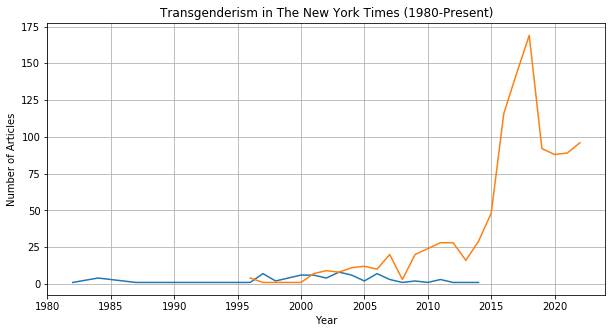

In [224]:
#PLOTS GRAPH 1
plt.figure(figsize=(10,5))
plt.plot(ts)
plt.plot(tg)

#create labels
plt.ylabel ("Number of Articles")
plt.xlabel ("Year")
plt.title("Transgenderism in The New York Times (1980-Present)")

#create legend

plt.grid()
plt.show()

In [231]:
#Groups by Category
by_category_db=nytimes_trans_db_cleaned.groupby(['Category']).count()

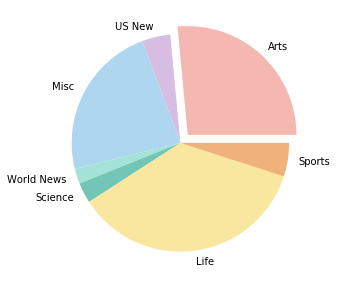

In [243]:
#
plt.figure(figsize=(10,5))

#Create Labels
labels=nytimes_trans_db_cleaned['Category'].unique()
sizes=by_category_db['Headline']
colors=['#F5B7B1','#D7BDE2','#AED6F1','#A3E4D7','#73C6B6','#F9E79F','#F0B27A']
explode=(.1,0,0,0,0,0,0)

#Plot Graph
plt.pie(sizes,explode=explode,colors=colors,labels=labels)
plt.show()

In [3]:
a=[10,20,30]
test_df=pd.DataFrame({'apples':a})
test_df['bananas']=test_df['apples']*2
test_df

,apples,bananas
0,10,20
1,20,40
2,30,60


In [115]:
sample[20,30]
for i, row in test_df.iterrows():
    print(row['Category'])
    for key, value in categories.items():
        if row['Category'] in value:
            test_df.loc[i,'Category']=key

1


,apples,bananas
0,10,20
1,20,80
2,30,60


In [85]:
#test_df['apples']
test_df.loc[0,'apples']=30
test_df

,apples,bananas
0,30,20
1,20,40
2,30,60


In [4]:
#1)Scrape the Mars News Site and collect the latest News Title and Paragraph Text
url='https://redplanetscience.com/'
soup=parser(url)

#declare variables -- originally I read the above as finding all the latest News Titles and decided to keep it for practice
mars_titles=[]
mars_paragraphs=[]

#scrape titles
results=soup.find_all('div', class_='content_title')

#append titles to list
for result in results:
    mars_titles.append(result.text.strip())

#assign the most recent title to a variable 
news_title=mars_titles[0]

#print results to verify
news_title

"NASA's Curiosity Takes Selfie With 'Mary Anning' on the Red Planet"

In [42]:
categories['Politics']

['Politics', 'Elections']

In [5]:
#scrape paragraph
results=soup.find_all('div', 'article_teaser_body')

#append paragraphs to list
for result in results:
    mars_paragraphs.append(result.text.strip())
    
#save 1st paragraph
news_p=mars_paragraphs[0]

print (news_p)

The Mars rover has drilled three samples of rock in this clay-enriched region since arriving in July.


In [6]:
#2)Visit the url for the Featured Space Image site here.

#parse feature image site
url='https://spaceimages-mars.com/'
soup=parser(url)

In [7]:
#Use splinter to navigate the site and find the image url for the current Featured Mars Image
browser.links.find_by_partial_text('FULL IMAGE').click()

#store new html
html = browser.html
soup = BeautifulSoup(html, 'html.parser')

#save feature image source
result=soup.find('img', class_='fancybox-image')
featured_image_url=url+result['src']

print(featured_image_url)

https://spaceimages-mars.com/image/featured/mars2.jpg


In [8]:
#Visit the Mars Facts webpage here and use Pandas to scrape the table

url='https://galaxyfacts-mars.com/'
tables=pd.read_html(url)

In [9]:
#Use Pandas to convert the data to a HTML table string.
the_table=tables[0].set_index(0)
the_table.rename(columns={1:'Mars',2:'Earth'},inplace=True)
the_table.index.names = ['Description']

#set table to html
the_table_html=the_table.to_html()

#print to verify
the_table

,Mars,Earth
Description,,
Mars - Earth Comparison,Mars,Earth
Diameter:,"6,779 km","12,742 km"
Mass:,6.39 × 10^23 kg,5.97 × 10^24 kg
Moons:,2,1
Distance from Sun:,"227,943,824 km","149,598,262 km"
Length of Year:,687 Earth days,365.24 days
Temperature:,-87 to -5 °C,-88 to 58°C


In [10]:
#function to pull the image url
def imagePull(hemisphere):
    
    #click on link for hemisphere
    browser.links.find_by_partial_text(hemisphere).click()
    
    #parse the new browser
    html = browser.html
    temp = BeautifulSoup(html, 'html.parser')
    
    #find the large image file
    the_image=temp.find('a',text='Sample')
    
    #move back to original page
    browser.links.find_by_partial_text('Back').click()

    return the_image['href']

#----------------------------------------------------
#list to store dictionary of image url and title
hemisphere_image_urls=[]

#open the page
url='https://marshemispheres.com/'
soup=parser(url)

#finds link names
links=soup.find_all('h3')

#loops through the first four links
for link in links:
    if link.text !='Back':
        the_image_url=f'{url}{imagePull(link.text)}'
        
        #append the list with a dictionary
        hemisphere_image_urls.append({"title": link.text, "img_url":the_image_url})

hemisphere_image_urls

[{'title': 'Cerberus Hemisphere Enhanced',
  'img_url': 'https://marshemispheres.com/images/full.jpg'},
 {'title': 'Schiaparelli Hemisphere Enhanced',
  'img_url': 'https://marshemispheres.com/images/schiaparelli_enhanced-full.jpg'},
 {'title': 'Syrtis Major Hemisphere Enhanced',
  'img_url': 'https://marshemispheres.com/images/syrtis_major_enhanced-full.jpg'},
 {'title': 'Valles Marineris Hemisphere Enhanced',
  'img_url': 'https://marshemispheres.com/images/valles_marineris_enhanced-full.jpg'}]

In [11]:
#return a dictionary of all the scraped data
scraped_data={
    "latest_title":news_title,"latest_p":news_p,
    "featured_image":featured_image_url,
    "the_table":the_table_html,
    "the_hemispheres":hemisphere_image_urls    
}

In [705]:
browser.quit()